In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

## KL divergence KL[q(w)||p(w)]

In [20]:
def kl_divergence(mu, cov):
    """
    computes the KL divergence between a multivariate normal with mean (mu) and 
    covariance (cov) and a standard multivariate normal N(0,I)
    
    """
    n = mu.shape[0]
    kl = 0.5 * (-np.log(np.linalg.det(cov)) - n + np.trace(cov) + np.dot(mu.T,mu))
    return kl

## Random Fourier Features

In [21]:
from sklearn.base import BaseEstimator
from sklearn.exceptions import NotFittedError

# Random Fourier features class
class KernelRFF(BaseEstimator):
    """
    Approximates the feature map of a kernel by Monte Carlo approximation of 
    it's Fourier transform. Implements random Fourier features [1].
        
    Parameters
    ----------
    gamma : float
        Parameter of the Gaussian kernel exp(-gamma * w^2)
        
    D : int
        Number of Monte Carlo samples per feature
    
    [1] Rahimi, A., & Recht, B. (2008). Random features for large-scale kernel machines. 
        In Advances in neural information processing systems (pp. 1177-1184)
    """
    
    def __init__(self,  D=50): #gamma=1,
#         self.gamma = gamma
        self.D = D # num MC samples
        self.is_fitted = False 
    
    def fit(self, X):
        """
        Draws D samples for direction w and random offset b
        
        X : Data {array, matrix}, shape (n_samples, n_dimension) 
        
        Returns
        -------
        self : object
            Returns the direction vector w, the offset b and the boolean
            fitted.
        """
        
        dimension = X.shape[1] # dimension of the data
        self.w_direction = np.random.normal(size=(self.D, dimension)) #*np.sqrt(2 * self.gamma)
        self.b_offset = np.random.uniform(0, 2*np.pi, size=(1, self.D))
        self.is_fitted = True
        
        return self
    
    def _transform(self, X):
        """
        Apply the approximate feature map to X.
        
        Parameters
        ----------
        X : Data {array, matrix}, shape (n_samples, n_features)
        
        Returns
        -------
        Z : array of transformed features, shape (n_samples, n_components [D])
        """
        
        Xw = X.dot(self.w_direction.T)
        
        Z = np.sqrt(2 / self.D) * np.cos(Xw + self.b_offset)
        
        return Z
    
    def approx_kernel(self, X, Y=None, gamma=1, flag=False):
        """
        Computes the kernel gram matrix using the transformed Fourier features
        
        Parameters
        ----------
        X : Data {array, matrix}, shape (n_samples, n_features)
        
        Y : Data {array, matrix}, shape (n_samples, n_features)
        
        Returns
        -------
        K : gram matrix (n_samples, n_samples)
        """
        if not self.is_fitted:
            raise NotFittedError('Must call .fit(X) before the kernel can be approximated.')
                
        Zx = self._transform(X) 
        
        if Y is not None:
            Zy = self._transform(Y)
            K = Zx.dot(Zy.T) * np.sqrt(2 * gamma)
            
            if K.ndim > 2:
                print("Dimensions were changed and corrected ...")
                K = K.squeeze()
        else:
            K = Zx.dot(Zx.T) * np.sqrt(2 * gamma)
            
            
        
        return K

## Bayesian Regressor

In [25]:
from scipy.optimize import minimize

class BR():
    """
    
    """
    
    def __init__(self, num_rff_samples=2000):
        self.num_rff_samples = num_rff_samples
        self.is_fitted = False 
        
        # Instantiate RFF approximations to the design matrix
        self.kernel = KernelRFF(D=self.num_rff_samples)
        self.post_k_xs = KernelRFF(D=self.num_rff_samples)
        self.pre_k_xs = KernelRFF(D=self.num_rff_samples)
    
    def fit(self, X, Y, gamma=0.5, var_y=0.2, var_w=1, new_data=True):
        """
       
        """
        self.X = X
        self.Y = Y
        self.var_y = var_y
        self.gamma = gamma
        
        if not new_data and not self.is_fitted:
            raise NotFittedError('Must call .fit with new data first.')
         
        if new_data:
            self.kernel.fit(X)

        phi = np.append(np.ones((X.shape[0],1)), \
                        self.kernel.approx_kernel(X, X, gamma=self.gamma), axis=1)# Append ones for bias
        
        # prior covariance matrix to include in MAP solution
        pre_w = 1/var_w * np.eye(len(X)+1) 

        # Mean and covariance matrix for weights given x and y
        self.S = np.linalg.inv((phi.T).dot(phi) / self.var_y + pre_w) # posterior distribution covariance matrix
        self.mu = self.S.dot(phi.T).dot(Y)/self.var_y # MAP weights to use in mean(y*)
        
        # Mark as fitted
        self.is_fitted = True
        
        return self.mu, self.S, phi
    
    def optimise(self):
        """
        
        """
        
        initial_guess = [0, 0]

        result = minimize(self.upper_bound, initial_guess)
        print(result.message)
        
        return np.exp(result.x)
    
        
    def upper_bound(self, x0):
        """
        
        """
        
        print('x0: ', x0)
#         if x0.ndim == 2:
#             x0 = x0.squeeze()
        
        ####################################################
        # Issue occurs here where x0 changes from shape
        # x0:  [ 1.79685546 -4.70335651] to
        # x0:  [[ 1.79685546 -4.70335651]]
        ####################################################
    
        gamma, var_y = np.exp(x0)

        mu, S, phi = self.fit(self.X, self.Y, gamma=gamma, var_y=var_y, new_data=False)

        # KL divergence between posterior and prior on the weights
        kl = kl_divergence(mu, S)
        
        # Gaussian log likelihood
        N = self.X.shape[0]
        log_p = -(N/2)*np.log(2*np.pi*var_y) - ((0.5/var_y)*(self.Y - phi.dot(mu))**2).mean()
        
        # Variational upper bound
        upper_bound = -log_p + kl
        
        return upper_bound
            
    
    def predictive(self, xs):
        """
        
        """
        self.pre_k_xs.fit(xs)
        pred_phi_xs = np.append(np.ones((len(xs),1)), self.pre_k_xs.approx_kernel(xs, self.X, self.gamma), axis=1)# Append ones for bias
        
        mu_pred = pred_phi_xs.dot(self.mu) # calculate mean(y*)
        stdev_pred = (np.sum(pred_phi_xs.dot(self.S) * pred_phi_xs, axis = 1) + self.var_y) ** 0.5 # calculate Var(y*)^0.5
                
        return mu_pred, stdev_pred

## Make some data

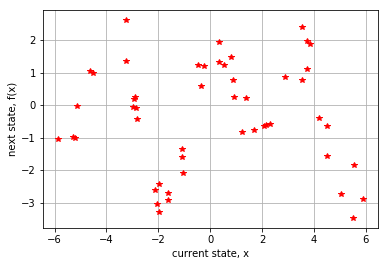

In [26]:
K = 50
var_input = 0.5
upper = 6
lower = -6
x_train = np.random.uniform(lower,upper,K)

fx = 1*np.sin(x_train) + 2*np.cos(np.sqrt(3)*x_train) #+ np.tan(x_train)
y_train = np.random.normal(fx, var_input)

x_train = x_train.reshape(-1,1)
y_train = y_train.reshape(-1,1)

plt.figure(1)
plt.plot(x_train, y_train, '*', color='red')
plt.xlabel("current state, x")
plt.ylabel("next state, f(x)")
plt.grid()

## Minimize 

In [28]:
br = BR()
br.fit(x_train, y_train)
br.optimise()

x0:  [0. 0.]
x0:  [1.49011612e-08 0.00000000e+00]
x0:  [0.00000000e+00 1.49011612e-08]
x0:  [0. 0.]
x0:  [-0.05775469 -1.00834736]
x0:  [-0.05775469 -1.00834736]
x0:  [-0.05775467 -1.00834736]
x0:  [-0.05775469 -1.00834734]
x0:  [-0.28877344 -5.04173679]
x0:  [-0.28877344 -5.04173679]
x0:  [-0.28877342 -5.04173679]
x0:  [-0.28877344 -5.04173678]
x0:  [ 0.59279424 -4.07557324]
x0:  [ 0.59279424 -4.07557324]
x0:  [ 0.59279426 -4.07557324]
x0:  [ 0.59279424 -4.07557322]
x0:  [-0.06672845 -4.79838421]
x0:  [-0.06672845 -4.79838421]
x0:  [-0.06672843 -4.79838421]
x0:  [-0.06672845 -4.79838419]
x0:  [ 4.53926224e-03 -4.82158839e+00]
x0:  [ 4.53926224e-03 -4.82158839e+00]
x0:  [ 4.53927714e-03 -4.82158839e+00]
x0:  [ 4.53926224e-03 -4.82158838e+00]
x0:  [-0.05672047 -4.80164272]
x0:  [-0.05672047 -4.80164272]
x0:  [-0.05672045 -4.80164272]
x0:  [-0.05672047 -4.80164271]
x0:  [-0.06180313 -4.80612878]
x0:  [-0.06180313 -4.80612878]
x0:  [-0.06180311 -4.80612878]
x0:  [-0.06180313 -4.80612877]


x0:  [-0.06194281 -4.80627291]
x0:  [-0.0619428  -4.80627291]
x0:  [-0.06194281 -4.8062729 ]
x0:  [-0.06194281 -4.80627291]
x0:  [-0.06194281 -4.80627291]
x0:  [-0.0619428  -4.80627291]
x0:  [-0.06194281 -4.8062729 ]
x0:  [-0.06194281 -4.80627291]
x0:  [-0.06194281 -4.80627291]
x0:  [-0.0619428  -4.80627291]
x0:  [-0.06194281 -4.8062729 ]
x0:  [-0.06194281 -4.80627291]
x0:  [-0.06194281 -4.80627291]
x0:  [-0.0619428  -4.80627291]
x0:  [-0.06194281 -4.8062729 ]
x0:  [-0.06194281 -4.80627291]
x0:  [-0.06194281 -4.80627291]
x0:  [-0.0619428  -4.80627291]
x0:  [-0.06194281 -4.8062729 ]
x0:  [-0.06194281 -4.80627291]
x0:  [-0.06194281 -4.80627291]
x0:  [-0.0619428  -4.80627291]
x0:  [-0.06194281 -4.8062729 ]
x0:  [-0.06194281 -4.80627291]
x0:  [-0.06194281 -4.80627291]
x0:  [-0.0619428  -4.80627291]
x0:  [-0.06194281 -4.8062729 ]
x0:  [-0.06194281 -4.80627291]
x0:  [-0.06194281 -4.80627291]
x0:  [-0.0619428  -4.80627291]
x0:  [-0.06194281 -4.8062729 ]
x0:  [-0.06194281 -4.80627291]
x0:  [-0

ValueError: not enough values to unpack (expected 2, got 1)

## Plot predictive distribution

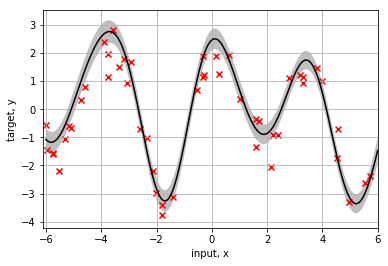

In [19]:
xs = np.linspace(-6,6, 1000).reshape(-1,1)
mu, stdev = br.predictive(xs)

plt.fill_between(xs.squeeze(), mu.squeeze() + 2*stdev.squeeze(), mu.squeeze() - 2*stdev.squeeze(), facecolor = 'grey', alpha = 0.5) # plot confidence intervals = +/- Var(y*)^0.5
plt.scatter(x_train, y_train, marker = 'x', color = 'red') # plot data
plt.plot(xs, mu, color = 'black')
plt.grid()
plt.xlabel('input, x')
plt.ylabel('target, y')
plt.autoscale(enable=True, axis='x', tight=True)
plt.show()